In [1]:
import os
import random
import numpy as np
import pandas as pd
import json
import gensim
import re
import pandas as pd
import gc
import networkx as nx
from scipy.sparse import lil_matrix
from scipy.io import mmwrite, mmread
from collections import defaultdict

aminer_dir = '../data/original'
outputDir = '../data/graph'
word2vec = gensim.models.KeyedVectors.load_word2vec_format('../data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

/Users/shohei/.pyenv/versions/anaconda3-5.3.0/envs/tensorenv/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [2]:
import datetime
date2 = datetime.datetime.now()
print(date2)

2021-01-13 09:31:43.983345


In [3]:
#attribute_set = {'title', 'authors', 'venue', 'year', 'n_citation', 'references', 'abstract'}
attribute_set = {'title', 'venue', 'year', 'references'}

paper = {}
for file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:
#for file in ['dblp-ref-3.json']:
    with open(os.path.join(aminer_dir, file)) as f:
        for line in f:
            empty_flag = 0
            data = json.loads(line)
            paper_id = data.pop('id')
            if attribute_set & data.keys() != attribute_set:
                continue
            for attribute in attribute_set:
                if attribute == 'year' or attribute == 'n_citation':
                    continue
                if len(data[attribute]) == 0:
                    empty_flag = 1
            if empty_flag == 0:
                paper[paper_id] = data

len(paper)

2154706

In [4]:
venue_list = list(pd.read_table("venue2.csv")['venue'])
venue_list = venue_list[:-4] # OSは除去
print(len(venue_list))

56


/Users/shohei/.pyenv/versions/anaconda3-5.3.0/envs/tensorenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [72]:
paper = {}
attribute_set = {'title', 'venue', 'year', 'references'}
for file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:
    with open(os.path.join(aminer_dir, file)) as f:
        for line in f:
            empty_flag = 0
            data = json.loads(line)
            paper_id = data.pop('id')
            if attribute_set & data.keys() != attribute_set:
                continue
            if data['year'] >= 2014: # 2014以降は使わない (後半の増え方が急すぎるため、graph size prediction がうまくできない)
                continue
            for attribute in attribute_set:
                if attribute == 'year' or attribute == 'n_citation':
                    continue
                if len(data[attribute]) == 0:
                    empty_flag = 1
            if not random.randrange(9) in set(range(1)): # 1/9にサブサンプリング
                continue
            if empty_flag == 0:
                if data['venue'] in venue_list:
                    #if data['year'] == 2017: # 2017が極端に少ないので2016とする
                    #    data['year'] = 2016
                    paper[paper_id] = data

len(paper)

10987

In [73]:
venue_count_dic = {}
for venue in venue_list:
    venue_count_dic[venue] = 0

for paper_id, meta in paper.items():
    venue_count_dic[meta['venue']] += 1

In [74]:
""""
G = nx.Graph()
year = 2018
paper_id_set = set()

for paper_id, meta in paper.items():
    if year < meta['year']:
        continue
    paper_id_set.add(paper_id)
print("node num : ",len(paper_id_set))

for paper_id in paper_id_set:
    G.add_node(paper_id)
    for reference_id in paper[paper_id]['references']:
        if not reference_id in paper_id_set:
            continue
        G.add_edge(paper_id, reference_id)
print("edge num : ",len(G.edges))
"""

'"\nG = nx.Graph()\nyear = 2018\npaper_id_set = set()\n\nfor paper_id, meta in paper.items():\n    if year < meta[\'year\']:\n        continue\n    paper_id_set.add(paper_id)\nprint("node num : ",len(paper_id_set))\n\nfor paper_id in paper_id_set:\n    G.add_node(paper_id)\n    for reference_id in paper[paper_id][\'references\']:\n        if not reference_id in paper_id_set:\n            continue\n        G.add_edge(paper_id, reference_id)\nprint("edge num : ",len(G.edges))\n'

In [75]:
"""
connected_component = {}
max_scale = 0
for c in nx.connected_components(G):
    sg = G.subgraph(c)
    if max_scale < len(sg.nodes):
        max_scale = len(sg.nodes)
        max_sg = G.subgraph(c)
    if not len(sg.nodes) in connected_component.keys():
        connected_component[len(sg.nodes)] = 1
    else:
        connected_component[len(sg.nodes)] += 1
connected_component
"""

'\nconnected_component = {}\nmax_scale = 0\nfor c in nx.connected_components(G):\n    sg = G.subgraph(c)\n    if max_scale < len(sg.nodes):\n        max_scale = len(sg.nodes)\n        max_sg = G.subgraph(c)\n    if not len(sg.nodes) in connected_component.keys():\n        connected_component[len(sg.nodes)] = 1\n    else:\n        connected_component[len(sg.nodes)] += 1\nconnected_component\n'

In [76]:
"""
node_idx_table = {}
for idx, node in enumerate(max_sg.nodes):
    node_idx_table[node] = idx
"""

'\nnode_idx_table = {}\nfor idx, node in enumerate(max_sg.nodes):\n    node_idx_table[node] = idx\n'

In [77]:
node_idx_table = {}
for idx, node in enumerate(paper.keys()):
    node_idx_table[node] = idx

In [80]:
rows = []
for node, idx in node_idx_table.items():
    rows.append([node, idx])
df = pd.DataFrame(rows, columns=['node', 'ID'])
df.to_csv(outputDir + '/node_idx.csv', index=False, encoding='utf_8_sig')

In [81]:
"""
paper = {}
for file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:
#for file in ['dblp-ref-3.json']:
    with open(os.path.join(aminer_dir, file)) as f:
        for line in f:
            empty_flag = 0
            data = json.loads(line)
            paper_id = data.pop('id')
            if not paper_id in node_idx_table:
                continue
            if attribute_set & data.keys() != attribute_set:
                continue
            for attribute in attribute_set:
                if attribute == 'year' or attribute == 'n_citation':
                    continue
                if len(data[attribute]) == 0:
                    empty_flag = 1
            if empty_flag == 0:
                paper[paper_id] = data

len(paper)
"""

"\npaper = {}\nfor file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:\n#for file in ['dblp-ref-3.json']:\n    with open(os.path.join(aminer_dir, file)) as f:\n        for line in f:\n            empty_flag = 0\n            data = json.loads(line)\n            paper_id = data.pop('id')\n            if not paper_id in node_idx_table:\n                continue\n            if attribute_set & data.keys() != attribute_set:\n                continue\n            for attribute in attribute_set:\n                if attribute == 'year' or attribute == 'n_citation':\n                    continue\n                if len(data[attribute]) == 0:\n                    empty_flag = 1\n            if empty_flag == 0:\n                paper[paper_id] = data\n\nlen(paper)\n"

In [82]:
#venue_set = set()
#for paper_id, meta in paper.items():
#    venue_set.add(meta['venue'])

In [83]:
#df = pd.DataFrame({'venue': list(venue_set)})
#df.to_csv("venue.csv")

In [84]:
years = set()
for paper_id, meta in paper.items():
    years.add(paper[paper_id]['year'])
years = list(years)
years.sort()
years

[1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013]

In [85]:
#field_list = ["WEB", "ML", "DM", "IR", "DB", "HI", "NLP", "CV", "COM", "OS"]
field_list = ["WEB", "ML", "DM", "IR", "DB", "HI", "NLP", "CV", "COM"]
field_venue_dic = defaultdict(list)

for idx, venue in enumerate(venue_list):
    if idx < 5:
        field_venue_dic["WEB"].append(venue)
    elif idx < 12:
        field_venue_dic["ML"].append(venue)
    elif idx < 19:
        field_venue_dic["DM"].append(venue)
    elif idx < 25:
        field_venue_dic["IR"].append(venue)
    elif idx < 34:
        field_venue_dic["DB"].append(venue)
    elif idx < 42:
        field_venue_dic["HI"].append(venue)
    elif idx < 47:
        field_venue_dic["NLP"].append(venue)
    elif idx < 51:
        field_venue_dic["CV"].append(venue)
    elif idx < 56:
        field_venue_dic["COM"].append(venue)
    #else:
    #    field_venue_dic["OS"].append(venue)

field_venue_dic

defaultdict(list,
            {'WEB': ['World Wide Web',
              'international world wide web conferences',
              'international semantic web conference',
              'Journal of Web Semantics',
              'european semantic web conference'],
             'ML': ['Artificial Intelligence',
              'international joint conference on artificial intelligence',
              'international conference on neural information processing',
              'neural information processing systems',
              'international conference on machine learning',
              'Machine Learning',
              'international conference on learning representations'],
             'DM': ['Sigkdd Explorations',
              'Data Mining and Knowledge Discovery',
              'workshop on knowledge discovery and data mining',
              'knowledge discovery and data mining',
              'international conference on data mining',
              'siam international conference on

In [86]:
field_count_dic = {}
for field in field_list:
    field_count_dic[field] = 0

for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    field_count_dic[field] += 1

field_count_dic

{'WEB': 549,
 'ML': 1893,
 'DM': 952,
 'IR': 822,
 'DB': 1320,
 'HI': 1355,
 'NLP': 1177,
 'CV': 1595,
 'COM': 1324}

In [87]:
year_field_count = np.zeros((len(years), len(field_list)))
for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    year_field_count[years.index(meta['year'])][field_list.index(field)] +=1

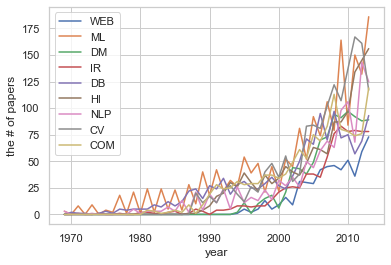

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

for f_idx in range(len(field_list)):
    plt.plot(years, year_field_count[:, f_idx], label=field_list[f_idx])
plt.xlabel("year")
plt.ylabel("the # of papers")
plt.legend()
plt.savefig("num_of_paper_field.pdf")

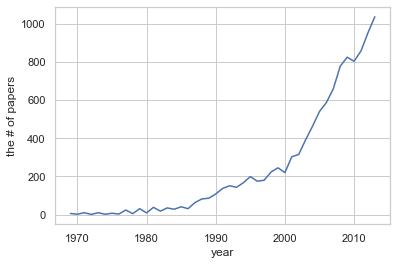

In [89]:
plt.figure()
plt.plot(years, year_field_count.sum(axis=1))
plt.xlabel("year")
plt.ylabel("the # of papers")
plt.savefig("num_of_paper.pdf")

In [90]:
node_attribute = np.zeros((len(node_idx_table), 300))
for paper_id, meta in paper.items():
    vector = np.zeros((300))
    #print(meta['title'])
    n_word = 0
    for word in meta['title'].split(' '):
        try:
            vector = vector + word2vec[word]
            n_word += 1
            #print(word)
        except KeyError as error:
            pass
            #print(error)
    if n_word == 0:
        node_attribute[node_idx_table[paper_id]] = vector
    else:
        node_attribute[node_idx_table[paper_id]] = vector / n_word
    #print(node_attribute[node_idx_table[paper_id]])
    #print(" ")

In [91]:
# 低次元に写像しクラスタを可視化
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
node_attribute_pca = pca.fit_transform(node_attribute)
print(node_attribute_pca.shape)

(10987, 2)


In [92]:
n_clusters = len(field_list)
x_field = [[] for _ in range(n_clusters)]
y_field = [[] for _ in range(n_clusters)]
for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    i = field_list.index(field)
    x_field[i].append(node_attribute_pca[node_idx_table[paper_id]][0])
    y_field[i].append(node_attribute_pca[node_idx_table[paper_id]][1])

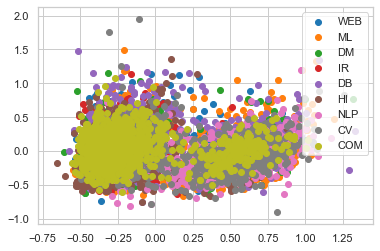

In [93]:
import matplotlib.colors as mcolors
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = [val for key, val in mcolors.TABLEAU_COLORS.items()]

for i in range(n_clusters):
    ax.scatter(x_field[i], y_field[i], c=colors[i], label=field_list[i])

ax.legend()
fig.savefig('scatter_word2vec.pdf')

In [94]:
# 分野ごとの論文を抽出して連結し文書化する。

def Isalnum(s):
    alnumReg = re.compile(r'^[a-zA-Z0-9]+$')
    return alnumReg.match(s) is not None

n_clusters = len(field_list)

cluster_title_list = [[] for _ in range(n_clusters)]
for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    cluster_title_list[field_list.index(field)].append(meta['title'])

documents = []
for title_list in cluster_title_list:
    title_list = ' '.join(title_list)
    title_list = str.lower(title_list)
    notalnum = set()
    for s in set(title_list):
        if s != ' ' and not Isalnum(s):
            notalnum.add(s)
            #print(s) # 記号（文字や数値でないもの）
    for s in notalnum:
        title_list = title_list.replace(s, ' ')
    documents.append(title_list)

In [95]:
# TF-IDFを計算し、各クラスタごとの代表的な単語を上位数件表示する。

from gensim import corpora
from gensim import models

# gensim用に整形
texts = list(map(lambda x:x.split(),documents))

# 単語->id変換の辞書作成
dictionary = corpora.Dictionary(texts)
#print(dictionary.token2id)

# textsをcorpus化
corpus = list(map(dictionary.doc2bow,texts))
#print(corpus)

# tfidf modelの生成
test_model = models.TfidfModel(corpus)

# corpusへのモデル適用
corpus_tfidf = test_model[corpus]

texts_tfidf = []
for doc in corpus_tfidf:
    text_tfidf = []
    for word in doc:
        text_tfidf.append((dictionary[word[0]],word[1]))
    texts_tfidf.append(text_tfidf)

keyword_tfidf_cluster_list = []
for idx, text in enumerate(texts_tfidf):
    print(field_list[idx])
    keyword_tfidf_cluster_list.append({})
    for keyword in sorted(text, key=lambda x:(x[1]), reverse=True)[:150]:
        print('   %.3f %s' %(keyword[1], keyword[0]))
        keyword_tfidf_cluster_list[idx][keyword[0]] = keyword[1]

WEB
   0.297 owl
   0.251 ontologies
   0.229 xml
   0.170 sparql
   0.160 rdf
   0.156 semantic
   0.148 provenance
   0.135 ontology
   0.093 hypermedia
   0.093 matchmaking
   0.093 ourspaces
   0.093 p2p
   0.091 news
   0.089 services
   0.085 wiki
   0.085 www
   0.083 linked
   0.080 infrastructure
   0.075 metadata
   0.067 service
   0.064 alignments
   0.064 dl
   0.064 intent
   0.064 semantically
   0.062 abox
   0.062 advertising
   0.062 blank
   0.062 catching
   0.062 directories
   0.062 earthquake
   0.062 hosting
   0.062 irs
   0.062 java
   0.062 marketplace
   0.062 metamodeling
   0.062 microblogging
   0.062 nsparql
   0.057 client
   0.057 querying
   0.050 communities
   0.046 cache
   0.046 conjunctive
   0.046 navigational
   0.046 crawling
   0.046 federated
   0.046 interoperability
   0.046 named
   0.046 repositories
   0.046 technologies
   0.042 areas
   0.042 captchas
   0.042 casual
   0.042 citizen
   0.042 freshness
   0.042 heritage
   0.042 html


In [96]:
#for paper_id, meta in paper.items():
#    if 'sigir' in str.lower(meta['title']):
#        print(meta['title'])

In [97]:
#key_ = ["WWW_keyword", "WWW_score", "ML_keyword", "ML_score", "DM_keyword", "DM_score", "IR_keyword", "IR_score", "DB_keyword", "DB_score", "HI_keyword", "HI_score", "NLP_keyword", "NLP_score", "CV_keyword", "CV_score", "COM_keyword", "COM_score", "OS_keyword", "OS_score"]
key_ = ["WWW_keyword", "WWW_score", "ML_keyword", "ML_score", "DM_keyword", "DM_score", "IR_keyword", "IR_score", "DB_keyword", "DB_score", "HI_keyword", "HI_score", "NLP_keyword", "NLP_score", "CV_keyword", "CV_score", "COM_keyword", "COM_score"]
val_ = []
for idx in range(n_clusters):
    val_.append([keyword for keyword, score in keyword_tfidf_cluster_list[idx].items()])
    val_.append([score for keyword, score in keyword_tfidf_cluster_list[idx].items()])
dic = {key_[i] : val_[i] for i in range(len(key_))}
df = pd.DataFrame(dic)
df.to_csv("field_tfidf.csv")
df.head()

,WWW_keyword,WWW_score,ML_keyword,ML_score,DM_keyword,DM_score,IR_keyword,IR_score,DB_keyword,DB_score,HI_keyword,HI_score,NLP_keyword,NLP_score,CV_keyword,CV_score,COM_keyword,COM_score
0,owl,0.296692,neural,0.279790,frequent,0.316763,workshop,0.157604,xml,0.347913,hci,0.254487,phrase,0.223609,shape,0.283880,atm,0.331306
1,ontologies,0.251370,eeg,0.103624,kdd,0.219298,judgments,0.147286,concurrency,0.239663,tangible,0.221293,distributional,0.217772,stereo,0.257800,multicast,0.295163
2,xml,0.228518,proving,0.096332,microarray,0.133437,latent,0.126083,dbms,0.174995,displays,0.166631,lexicon,0.190482,motion,0.230637,routing,0.264559
3,sparql,0.169538,spike,0.096332,rules,0.130397,xml,0.119590,transaction,0.153120,work,0.165970,parsing,0.183073,pose,0.225655,qos,0.252997
4,rdf,0.159963,theories,0.094204,cup,0.121832,recommendations,0.118203,integrity,0.143798,touch,0.154905,parser,0.173918,vision,0.177502,tcp,0.252997


In [98]:
#用いるキーワード数
n_used_keyword = 50
field_used_keyword = {}

field_attribute = np.zeros((len(field_list), 300))
for field in range(n_clusters):
    vector = np.zeros((300))
    n_word = 0
    #weight = n_used_keyword
    weight = 0
    used_keyword = []
    for word in val_[field * 2]:
        try:
            #vector = vector + weight * word2vec[word]
            w = keyword_tfidf_cluster_list[field][word]
            vector = vector + w * word2vec[word]
            n_word += 1
            #weight -= 1
            weight += w
            used_keyword.append(word)
            #print(word)
        except KeyError as error:
            pass
            #print(word)
        if n_word == n_used_keyword:
            break
    if n_word == 0 or n_word < n_used_keyword:
        print("あり得ない")
        field_attribute[field] = vector
    else:
        #field_attribute[field] = vector / sum(i for i in range(1, n_used_keyword+1))
        field_attribute[field] = vector / weight
    field_used_keyword[field_list[field]] = used_keyword

In [99]:
df = pd.DataFrame(field_used_keyword)
df.to_csv("used_word.csv")

In [100]:
print(field_attribute.shape)
print(node_attribute.shape)

(9, 300)
(10987, 300)


In [101]:
import sklearn
node_attribute_similar2field = sklearn.metrics.pairwise.cosine_similarity(node_attribute, field_attribute)
node_attribute_similar2field.shape

(10987, 9)

In [102]:
# 低次元に写像しクラスタを可視化
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
node_attribute_pca = pca.fit_transform(node_attribute_similar2field)
print(node_attribute_pca.shape)

(10987, 2)


In [103]:
x_field = [[] for _ in range(n_clusters)]
y_field = [[] for _ in range(n_clusters)]
for paper_id, meta in paper.items():
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    i = field_list.index(field)
    x_field[i].append(node_attribute_pca[node_idx_table[paper_id]][0])
    y_field[i].append(node_attribute_pca[node_idx_table[paper_id]][1])

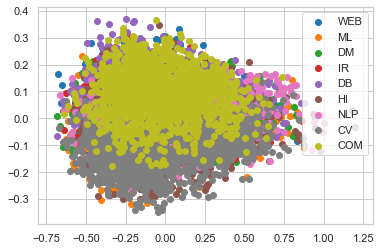

In [104]:
import matplotlib.colors as mcolors
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = [val for key, val in mcolors.TABLEAU_COLORS.items()]

for i in range(n_clusters):
    ax.scatter(x_field[i], y_field[i], c=colors[i], label=field_list[i])

ax.legend()
fig.savefig('scatter_sim2refvec.pdf')

In [105]:
# 低次元に写像しクラスタを可視化
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
field_attribute_pca = pca.fit_transform(field_attribute)
print(field_attribute_pca.shape)

(9, 2)


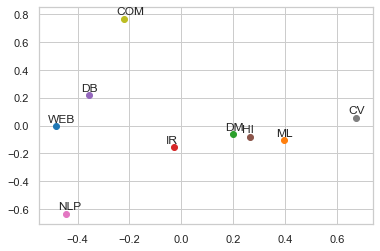

In [106]:
import matplotlib.colors as mcolors
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = [val for key, val in mcolors.TABLEAU_COLORS.items()]

for i in range(n_clusters):
    ax.scatter(field_attribute_pca[i][0], field_attribute_pca[i][1], c=colors[i], label=field_list[i])
    plt.annotate(field_list[i], xy=(field_attribute_pca[i][0]-0.03, field_attribute_pca[i][1]+0.03))

fig.savefig('scatter_field.pdf')

In [107]:
# ここで実際の分野とタイトルのそれらしさの一致率をチェック
for paper_id, meta in sorted(paper.items())[:10]:
    field = [f for f, vl in field_venue_dic.items() if meta['venue'] in vl][0]
    print(field, field_list[node_attribute_similar2field[node_idx_table[paper_id]].argmax()])
    print(meta['title'])

IR DB
A relational algebra for data/metadata integration in a federated database system
DB DB
Data exchange beyond complete data
NLP WEB
A Dutch to SQL database interface using generalized quantifier theory
DM DM
Joint cluster analysis of attribute and relationship data withouta-priori specification of the number of clusters
ML ML
The Use of MDL to Select among Computational Models of Cognition
CV CV
Concentric mosaic(s), planar motion and 1D cameras
CV CV
A framework for spatiotemporal control in the tracking of visual contours
CV HI
Fast, integrated person tracking and activity recognition with plan-view templates from a single stereo camera
IR WEB
Mining networks with shared items
DM DM
Fast algorithms for maximal clique enumeration with limited memory


In [108]:
node_attribute_similar2field

array([[0.55437997, 0.27970422, 0.3537121 , ..., 0.36297518, 0.23573729,
        0.2806318 ],
       [0.35490264, 0.33064982, 0.34277111, ..., 0.29847845, 0.20350156,
        0.20460046],
       [0.45299685, 0.39322968, 0.42011247, ..., 0.37721345, 0.38439797,
        0.42115462],
       ...,
       [0.39147995, 0.44566942, 0.44723264, ..., 0.37261129, 0.29660248,
        0.38574359],
       [0.50604248, 0.54685165, 0.51977107, ..., 0.45781674, 0.49855499,
        0.39347991],
       [0.57844215, 0.52452058, 0.59730753, ..., 0.48599711, 0.40275177,
        0.4638422 ]])

In [109]:
rows = []
for idx, ts in enumerate(years):
    rows.append([ts, idx])
df = pd.DataFrame(rows, columns=['TS', 'ID'])
df.to_csv(outputDir + '/ts_idx.csv', index=False, encoding='utf_8_sig')

In [110]:
df = pd.read_csv(outputDir + '/ts_idx.csv')
df_TS = df.TS.values
df_ID = df.ID.values
ts_idx_table = {}
for row in range(df.shape[0]):
    ts_idx_table[df_TS[row]] = df_ID[row]

In [111]:
exist_table = np.zeros((len(node_idx_table), len(ts_idx_table)))
for year in years:
    for paper_id, meta in paper.items():
        if year < meta['year']:
            exist_table[node_idx_table[paper_id]][ts_idx_table[year]] = 0
        else:
            exist_table[node_idx_table[paper_id]][ts_idx_table[year]] = 1

np.save(outputDir + '/exist_table', exist_table)

In [112]:
for year in years:
    node_attribute = np.zeros((len(node_idx_table), len(field_list)))
    index = exist_table[:, ts_idx_table[year]] == 1
    node_attribute[index] = node_attribute_similar2field[index]
    np.save(outputDir + '/node_attribute' + str(ts_idx_table[year]), node_attribute)

In [113]:
for year in years:
    adjacency = lil_matrix((len(node_idx_table), len(node_idx_table)))
    for paper_id, meta in paper.items():
        if year < meta['year']:
            continue
        for reference_id in meta['references']:
            if not reference_id in node_idx_table.keys():
                continue
            adjacency[node_idx_table[paper_id], node_idx_table[reference_id]] = 1
    mmwrite(outputDir + '/adjacency' + str(ts_idx_table[year]), adjacency)

In [114]:
exist_table.shape

(10987, 45)

In [134]:
exist_table[:, -1] == 1

array([ True,  True,  True, ...,  True,  True,  True])

In [136]:
node_attribute_similar2field.shape

(127980, 9)

In [137]:
len(field_list)

9

In [ ]:
# 従来の問題点1 : connected component は1だが、必ずしもnew nodeのreference先が存在するとは限らない
# 従来の問題点2 : 今回はnew node予測のみなので必ずしもexisting node の隣接行列等は必要ない
# 従来の問題点3 : サイズが大きすぎてdeep learningができない
# 従来の問題点4 : 属性のその他が多すぎる問題

# 方針1 : new nodeがreference先を1つ以上持つものをサンプリングする
# 方針2 : original (2118551)のグラフが持つ属性の割合を保持する (e.g. 1990年はdb:0.8, ml:0.2、1990年はdb:0.6, ml:0.4、・・・) ようにnew nodeをサンプリングする
# 方針3 : 方針1と方針2を満たすnew nodeとそのreference先のセットを1サンプルとする

# 方針3で作成されたグラフを時系列に組み合わせて新たな時系列グラフを作り直す。
# ただし、各サンプル（各タイムステップ）のexisting node（reference先のノード）はそのタイミングのみ存在するものとする。
# 次のタイミングでは過去のnew nodeもexisting nodeも消失ノードとする（new node 予測のみなので、消失予測は関係無い）
# new node & existing nodeが新たに出現し、すぐさま消失するイメージ
# new nodeの出現数もoriginalの等縮小倍率とする
#（本当は過去ノードは消失ノード扱いのため存在していないが）グラフとしてはサブサンプルされたnew node & existing nodeの累積個数とする。
# この方法で作成すれば一応、new nodeの数と属性の統計量を保持したままグラフを削れる

# → まずはグラフサイズを削る前に年ごとの属性の割合を明らかにする

In [ ]:
# 年ごとのpaper_id の辞書を作成
year_paper_dic = {}
for year in years:
    year_paper_dic[year] = []
for paper_id, meta in paper.items():
    year_paper_dic[meta['year']].append(paper_id)

# 年ごとのnew nodeの数を表示
for year in years:
    print(year, len(year_paper_dic[year]))

In [ ]:
node_attribute = np.zeros((len(node_idx_table), 300))
for paper_id, meta in paper.items():
    vector = np.zeros((300))
    #print(meta['title'])
    n_word = 0
    for word in meta['title'].split(' '):
        try:
            vector = vector + word2vec[word]
            n_word += 1
            #print(word)
        except KeyError as error:
            pass
            #print(error)
    if n_word == 0:
        node_attribute[node_idx_table[paper_id]] = vector
    else:
        node_attribute[node_idx_table[paper_id]] = vector / n_word
    #print(node_attribute[node_idx_table[paper_id]])
    #print(" ")

In [ ]:
# zero vectorの件数 (タイトル内のどの単語もword2vecのカバー範囲に含まれなかった件数)
sum(np.abs(node_attribute.sum(axis=1)) < 0.0000001)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
n_clusters = 10
kmeans_model = MiniBatchKMeans(n_clusters=n_clusters, batch_size=3000, random_state=42, max_iter=1000000, max_no_improvement=10000)
kmeans_model.fit(node_attribute)

In [ ]:
kmeans_model.labels_

In [ ]:
# 論文のラベルとしてcluster key を追加
for paper_id, meta in paper.items():
    paper[paper_id]["cluster"] = kmeans_model.labels_[node_idx_table[paper_id]]

In [ ]:
# クラスタごとの論文を抽出して連結し文書化する。

def Isalnum(s):
    alnumReg = re.compile(r'^[a-zA-Z0-9]+$')
    return alnumReg.match(s) is not None

cluster_title_list = [[] for _ in range(n_clusters)]
for paper_id, meta in paper.items():
    cluster_title_list[meta['cluster']].append(meta['title'])

documents = []
for title_list in cluster_title_list:
    title_list = ' '.join(title_list)
    title_list = str.lower(title_list)
    notalnum = set()
    for s in set(title_list):
        if s != ' ' and not Isalnum(s):
            notalnum.add(s)
            #print(s) # 記号（文字や数値でないもの）
    for s in notalnum:
        title_list = title_list.replace(s, ' ')
    documents.append(title_list)

In [ ]:
# TF-IDFを計算し、各クラスタごとの代表的な単語を上位数件表示する。

from gensim import corpora
from gensim import models

# gensim用に整形
texts = list(map(lambda x:x.split(),documents))

# 単語->id変換の辞書作成
dictionary = corpora.Dictionary(texts)
#print(dictionary.token2id)

# textsをcorpus化
corpus = list(map(dictionary.doc2bow,texts))
#print(corpus)

# tfidf modelの生成
test_model = models.TfidfModel(corpus)

# corpusへのモデル適用
corpus_tfidf = test_model[corpus]

texts_tfidf = []
for doc in corpus_tfidf:
    text_tfidf = []
    for word in doc:
        text_tfidf.append((dictionary[word[0]],word[1]))
    texts_tfidf.append(text_tfidf)

keyword_tfidf_cluster_list = []
for idx, text in enumerate(texts_tfidf):
    print('cluster:', idx)
    keyword_tfidf_cluster_list.append({})
    for keyword in sorted(text, key=lambda x:(x[1]), reverse=True)[:10]:
        print('   %.3f %s' %(keyword[1], keyword[0]))
        keyword_tfidf_cluster_list[idx][keyword[0]] = keyword[1]

In [ ]:
keyword_tfidf_cluster_list

In [ ]:
!pip install cmake
!pip install MulticoreTSNE

In [ ]:
# 低次元に写像しクラスタを可視化（めちゃくちゃ遅い！！！）
from MulticoreTSNE import MulticoreTSNE as TSNE
import multiprocessing

print(multiprocessing.cpu_count())
t_sne = TSNE(n_jobs=multiprocessing.cpu_count()).fit_transform(node_attribute)
print('t_sne shape:', t_sne.shape)

In [ ]:
aaa

In [ ]:
# 年ごとのクラスタの割合をプロット (Deep MatchMaxが学習できるヒントがあるかもしれない)

In [ ]:
aaa

In [ ]:
# pandas 高速化 https://kunai-lab.hatenablog.jp/entry/2018/04/08/134924
df = pd.read_csv(outputDir + '/node_idx.csv')
df_node = df.node.values
df_ID = df.ID.values
node_idx_table2 = {}
for row in range(df.shape[0]):
    node_idx_table2[df_node[row]] = df_ID[row]
assert node_idx_table2 == node_idx_table, "いってこいになってない"

del df, df_node, df_ID, node_idx_table2, connected_component, sg, max_sg, paper_id_set, G, paper
gc.collect()

In [ ]:
paper = {}
for file in ['dblp-ref-0.json', 'dblp-ref-1.json', 'dblp-ref-2.json', 'dblp-ref-3.json']:
#for file in ['dblp-ref-3.json']:
    with open(os.path.join(aminer_dir, file)) as f:
        for line in f:
            empty_flag = 0
            data = json.loads(line)
            paper_id = data.pop('id')
            if not paper_id in node_idx_table:
                continue
            if attribute_set & data.keys() != attribute_set:
                continue
            for attribute in attribute_set:
                if attribute == 'year' or attribute == 'n_citation':
                    continue
                if len(data[attribute]) == 0:
                    empty_flag = 1
            if empty_flag == 0:
                paper[paper_id] = data

len(paper)

In [ ]:
dict_id2title = {}
for paper_id in paper.keys():
    dict_id2title[paper_id] = paper[paper_id]['title']
len(dict_id2title)

In [ ]:
venue_dict = {}
for paper_id, meta in paper.items():
    if meta['venue'] in venue_dict.keys():
        venue_dict[meta['venue']] = venue_dict[meta['venue']] + 1
    else:
        venue_dict[meta['venue']] = 1

venue_list = []
for name, count in sorted(venue_dict.items(), key=lambda x: -x[1]):
    venue_list.append(name)

In [ ]:

def GetListIndex(l, x, default=-1):
    if x in l:
        return l.index(x)
    else:
        return default

def Isalnum(s):
    alnumReg = re.compile(r'^[a-zA-Z0-9]+$')
    return alnumReg.match(s) is not None

venue_list = venue_list[:100]
title_groupby_venue_defaultdict = defaultdict(list)
for paper_id, meta in paper.items():
    if GetListIndex(venue_list, meta['venue']) != -1:
        title_groupby_venue_defaultdict[meta['venue']].append(meta['title'])

document_groupby_venue_dict = {}
for venue in venue_list:
    title_list = title_groupby_venue_defaultdict[venue]
    title_list = ' '.join(title_list)
    title_list = str.lower(title_list)
    notalnum = []
    for s in title_list:
        if s != ' ' and not Isalnum(s):
            notalnum.append(s)
            #print(s) # 記号（文字や数値でないもの）
    for s in notalnum:
        title_list = title_list.replace(s, ' ')
    document_groupby_venue_dict[venue] = title_list

In [ ]:
rows = []
row = ['field', 0, 0, 100, 'VECTOR', True, False, False]
row.extend(sorted(venue_list))
row.extend(['other'])
rows.append(row)
columns = ['name', 'ID', 'range0', 'range1', 'type', 'primary', 'avg', 'cov']
classes = ['class' + str(i) for i in range(len(venue_list) + 1)]
columns.extend(classes)
df = pd.DataFrame(rows, columns=columns)
df.to_csv(outputDir + '/attribute_idx.csv', index=False, encoding='utf_8_sig')

In [ ]:
from gensim import corpora
from gensim import models

documents = []
for venue in venue_list:
    documents.append(document_groupby_venue_dict[venue])
    
# gensim用に整形
texts = list(map(lambda x:x.split(),documents))

# 単語->id変換の辞書作成
dictionary = corpora.Dictionary(texts)
#print(dictionary.token2id)

# textsをcorpus化
corpus = list(map(dictionary.doc2bow,texts))
#print(corpus)

# tfidf modelの生成
test_model = models.TfidfModel(corpus)

# corpusへのモデル適用
corpus_tfidf = test_model[corpus]

texts_tfidf = []
for doc in corpus_tfidf:
    text_tfidf = []
    for word in doc:
        text_tfidf.append((dictionary[word[0]],word[1]))
    texts_tfidf.append(text_tfidf)

keyword_tfidf_venue_dict = {}
for idx, text in enumerate(texts_tfidf):
    print(venue_list[idx])
    keyword_tfidf_venue_dict[venue_list[idx]] = {}
    for keyword in sorted(text, key=lambda x:(x[1]), reverse=True)[:10]:
        print('   %.3f %s' %(keyword[1], keyword[0]))
        keyword_tfidf_venue_dict[venue_list[idx]][keyword[0]] = keyword[1]

In [ ]:
title_venue_score = {}
for paper_id, meta in paper.items():
    title_venue_score[meta['title']] = {}
    word_list = meta['title'].split(' ')
    for venue, tfidf in keyword_tfidf_venue_dict.items():
        title_venue_score[meta['title']][venue] = 0
        for keyword, score in tfidf.items():
            for word in word_list:
                if keyword == str.lower(word):
                    title_venue_score[meta['title']][venue] = title_venue_score[meta['title']][venue] + score

In [ ]:
title_venue_dict = {}
number = 0
for title, venue_score_dict in title_venue_score.items():
    number += 1
    if number < 100:
        print(title)
    for venue, score in sorted(venue_score_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
        if number < 100:
            print('   %.3f %s' %(score, venue))
    #venue, score = sorted(venue_score_dict.items(), key=lambda x: x[1], reverse=True)[0]
    #if score == 0:
    #    title_venue_dict[title] = 'other'
    #    continue
    #title_venue_dict[title] = venue

In [ ]:
title_venue_dict = {}
for title, venue_score_dict in title_venue_score.items():
    #title_venue_dict[title] = [0 for _ in range(len(venue_list))]
    title_venue_dict[title] = {}
    for venue, score in venue_score_dict.items():
        #title_venue_dict[title][GetListIndex(venue_list, venue)] = score
        title_venue_dict[title][venue] = score
    #score_sum = sum(title_venue_dict[title])
    score_sum = sum([score for venue, score in title_venue_dict[title].items()])
    if score_sum == 0:
        continue
    #for idx, score in enumerate(title_venue_dict[title]):
    #    title_venue_dict[title][idx] = score / score_sum
    for venue, score in title_venue_dict[title].items():
        title_venue_dict[title][venue] = score / score_sum

for title, score_list in title_venue_dict.items():
    if title == 'Evolutionary Chaos Controller Synthesis for Stabilizing Chaotic Hénon Maps.':
        print(title)
        for venue, score in score_list.items():
            print(venue, score)

In [ ]:
years = set()
for paper_id, meta in paper.items():
    years.add(paper[paper_id]['year'])
years = list(years)
years.sort()
years

In [ ]:
rows = []
for idx, year in enumerate(years):
    rows.append([year, idx])
df = pd.DataFrame(rows, columns=['TS', 'ID'])
df.to_csv(outputDir + '/ts_idx.csv', index=False, encoding='utf_8_sig')

In [ ]:
# pandas 高速化 https://kunai-lab.hatenablog.jp/entry/2018/04/08/134924
df = pd.read_csv(outputDir + '/ts_idx.csv')
df_TS = df.TS.values
df_ID = df.ID.values
ts_idx_table = {}
for row in range(df.shape[0]):
    ts_idx_table[df_TS[row]] = df_ID[row]
ts_idx_table

In [ ]:
exist_table = np.zeros((len(node_idx_table), len(ts_idx_table)))
for year in years:
    for paper_id, meta in paper.items():
        if year < meta['year']:
            exist_table[node_idx_table[paper_id]][ts_idx_table[year]] = 0
        else:
            exist_table[node_idx_table[paper_id]][ts_idx_table[year]] = 1

np.save(outputDir + '/exist_table', exist_table)

In [ ]:
for year in years:
    node_attribute = np.zeros((len(node_idx_table), len(venue_list)+1))
    for paper_id, meta in paper.items():
        if year < meta['year']:
            continue
        field_vector = []
        for veneu, score in sorted(title_venue_dict[meta['title']].items(), key=lambda x:x[0]):
            field_vector.append(score)
        field_vector.append(0)
        if sum(field_vector) == 0:
            field_vector[100] = 1
        node_attribute[node_idx_table[paper_id]] = np.array(field_vector)
    np.save(outputDir + '/node_attribute' + str(ts_idx_table[year]), node_attribute)

In [ ]:
for year in years:
    adjacency = lil_matrix((len(node_idx_table), len(node_idx_table)))
    for paper_id, meta in paper.items():
        if year < meta['year']:
            continue
        for reference_id in meta['references']:
            if not reference_id in node_idx_table.keys():
                continue
            adjacency[node_idx_table[paper_id], node_idx_table[reference_id]] = 1
    mmwrite(outputDir + '/adjacency' + str(ts_idx_table[year]), adjacency)

In [ ]:
date2 = datetime.datetime.now()
print(date2)